In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_json("./data/info/train.json")
t_df = pd.read_json("./data/info/train_pairs.json")
s_df = pd.read_json("./data/info/synthetic_with_pairs.json")

In [ ]:
def get_fold_test_group_names(fold, df):
  names = np.array(df[df["group"] == fold]["file"])
  return [file.split(".")[0] for file in names]

In [ ]:
def get_selected_synthetic_match_scores(fold, s_df, pairs):
  all_scores = []
  s_df = s_df[(s_df.fold == fold) & (s_df.verieye_status == True)]    
  for match_scores in s_df["train_match_scores"]:    
    all_scores.append([row["score"] for row in match_scores if row["pair"] in pairs])
  return list(itertools.chain.from_iterable(all_scores))

In [ ]:
def get_random_synthetic_match_scores(fold, s_df, pairs):
  all_scores = []
  s_df = s_df[(s_df.fold == fold)].sample(n=400)    
  for match_scores in s_df["train_match_scores"]:    
    all_scores.append([row["score"] for row in match_scores if row["pair"] in pairs])
  return list(itertools.chain.from_iterable(all_scores))

In [ ]:
def get_genuine_test_pairs_match_scores(fold, t_df):
 return np.array(t_df[(t_df.group_first == fold) & (t_df.group_second == fold) & (t_df.type == "genuine")]["match_score"])

In [ ]:
def calculate_sfar(scores):
  thresholds = np.arange(0.0, 0.1, .001)
  sfarRatios = []
  for thold in thresholds:
    FA = 0
    for i in range(len(scores)):
      if(scores[i] > thold):
        FA = FA +1
    sfarRatios.append(FA/float(len(scores)))
  return sfarRatios 

In [ ]:
def calculate_frr(scores):
  thresholds = np.arange(0.0, 1.0, .01)
  frRatios = []
  for thold in thresholds:
    FR = 0
    for i in range(len(scores)):
      if(scores[i] < thold):
        FR = FR +1
    frRatios.append(FR/float(len(scores)))
  return frRatios

In [ ]:
SFAR_L = []
FRR_L = []
R_SFAR_L = []
markers = ["o", "v", "*", "+", "x", "2"]
for fold in range(1,6):
  pairs = get_fold_test_group_names(fold, df)
  s_scores = get_selected_synthetic_match_scores(fold, s_df, pairs) / np.array(1681) #1681 is VeriEye max value
  g_scores = get_genuine_test_pairs_match_scores(fold, t_df) / np.array(1681)
  SFAR = calculate_sfar(s_scores)
  FRR = calculate_frr(g_scores)
  SFAR_L.append(SFAR)
  FRR_L.append(FRR)
  plt.plot(SFAR, FRR, label="Selected",linewidth=2 , marker = markers[0])
  LST = []
  for i in range(1,6):
    rand_scores = get_random_synthetic_match_scores(fold, s_df, pairs) / np.array(1681)
    R_SFAR = calculate_sfar(rand_scores)
    LST.append({"fold":i, "type":"random", "rand": i,"SFAR": R_SFAR})
    plt.plot(R_SFAR, FRR, label=f"Rand-{i}",linewidth=2, marker = markers[i])
  R_SFAR_L.append(LST)
  plt.xscale("log")
  plt.grid()
  plt.legend()
  plt.title(f"SFAR - FRR Graph(Fold-{fold})")
  plt.xlabel("SFAR")
  plt.ylabel("FRR")
  plt.tight_layout()
  plt.savefig(f"sfar-ffr-{fold}.png", format="png", facecolor="white")
  plt.figure(figsize=(12,10))
  plt.show()

In [ ]:
sfar_avg = np.sum([score for score in SFAR_L], axis=0) / 5
frr_avg = np.sum([score for score in FRR_L], axis=0) / 5

In [ ]:
r_sfar_avgs = []
df = pd.DataFrame(R_SFAR_L)
for idx,row in enumerate(R_SFAR_L):
  items = df[idx]
  r_sfar_avgs.append(np.sum([item["SFAR"] for item in items], axis=0) / 5)

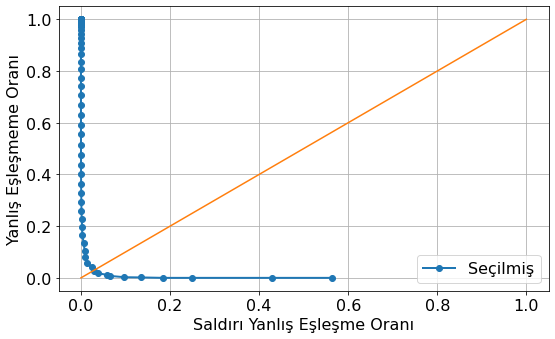

In [215]:
from shapely.geometry import LineString

ax_list=[]

plt.figure(figsize=(8,5))
ax = plt.plot(sfar_avg, frr_avg, label="Seçilmiş",linewidth=2, marker=markers[0])
ax_list.append({"name":"seçilmiş","ax": ax})
plt.plot([0,1])

first_line = LineString(np.column_stack((sfar_avg, frr_avg)))
second_line = LineString(np.column_stack(([0,1], [1,0])))
intersection = first_line.intersection(second_line)

# for i in range(1,6):
#   ax = plt.plot(r_sfar_avgs[i-1], frr_avg, label=f"Rastgele-{i}",linewidth=2, marker=markers[i])
#   ax_list.append({"name":f"rastgele-{i}","ax": ax})
# plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Saldırı Yanlış Eşleşme Oranı")
plt.ylabel("Yanlış Eşleşmeme Oranı")
plt.tight_layout()

plt.rcParams.update({'font.size': 16})
plt.savefig("sfar-frr-avg.png", format="png", facecolor="white")
plt.show()

In [239]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [259]:
eer = brentq(lambda x : 1. - x - interp1d(r_sfar_avgs[1], frr_avg,axis=0, fill_value="extrapolate")(x), 0., 1.)

In [260]:
eer

1.0

In [ ]:
scores = []
for i in range(100):
  frr = ax_list[0]["ax"][0].get_ydata()[i]
  sfar_s = ax_list[0]["ax"][0].get_xdata()[i]
  sfar_1 = ax_list[1]["ax"][0].get_xdata()[i]
  sfar_2 = ax_list[2]["ax"][0].get_xdata()[i]
  sfar_3 = ax_list[3]["ax"][0].get_xdata()[i]
  sfar_4 = ax_list[4]["ax"][0].get_xdata()[i]
  sfar_5 = ax_list[5]["ax"][0].get_xdata()[i]
  dct = {"FRR": frr, "SFAR-Seçilmiş": sfar_s, "SFAR-R1": sfar_1, "SFAR-R2": sfar_2, "SFAR-R3": sfar_3,"SFAR-R4": sfar_4,"SFAR-R5" : sfar_5}
  scores.append(dct)
pd.DataFrame(scores).to_csv("frr-sfar-pairs.csv", index=False)

In [ ]:
selected_scores = []
for match_scores in s_df[s_df["verieye_status"] == True]["train_match_scores"]:    
  selected_scores.append([row["score"] for row in match_scores])
selected_scores = list(itertools.chain.from_iterable(selected_scores))

In [ ]:
plt.hist(selected_scores, bins=50, edgecolor="black", alpha=.7)
plt.title("Seçilmiş Sentetik İmgelerin Atak Skor Dağılımı")
plt.ylabel("Frekans")
plt.xlabel("Atak Puanı")
plt.yscale("log")
plt.tight_layout()
plt.savefig("selected_score_dist.png", format="png", facecolor="white")
plt.show()

In [ ]:
df = pd.read_json("./data/info/train_pairs.json", orient="records")
genuine_scores = np.array(df[df["type"] == "genuine"]["match_score"])
impostor_scores = np.array(df[df["type"] == "impostor"]["match_score"])

In [ ]:
from collections import Counter

def normalize(scores):
  scores = Counter(scores)
  total = sum(scores.values(), 0.0)
  for key in scores:
    scores[key] /= total
  return scores

In [ ]:
# genuine_scores = normalize(genuine_scores)
impostor_scores = normalize(impostor_scores)

In [ ]:
all_scores = []
for match_scores in s_df["train_match_scores"]:    
  all_scores.append([row["score"] for row in match_scores])
all_scores = list(itertools.chain.from_iterable(all_scores))

In [ ]:

plt.hist(genuine_scores, density=True, bins=50, edgecolor="black", alpha=.4)
plt.hist(impostor_scores, density=True, bins=5, edgecolor="black", alpha = .4)
plt.hist(selected_scores, density=True, bins=50, edgecolor="black", alpha=.4)
# plt.hist(impostor_scores, density=True, bins=5, edgecolor="black", alpha = .6)

plt.xticks(np.arange(0,1000, 100))

plt.ylabel("Frekans")
plt.xlabel("Atak Puanı")
plt.tight_layout()
plt.legend(['Eş Olan', 'Eş Olmayan'])
# plt.savefig("train_score_dist.png", format="png", facecolor="white")
plt.show()

In [ ]:
plt.hist(all_scores, bins=50, edgecolor="black", alpha=.7)
plt.title("Tüm Sentetik İmgelerin Atak Skor Dağılımı")
plt.ylabel("Frekans")
plt.xlabel("Atak Puanı")
plt.yscale("log")
plt.tight_layout()
plt.savefig("all_synthetic_score_dist.png", format="png", facecolor="white")
plt.show()